In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# confirm TensorFlow sees the GPU
from tensorflow.python.client import device_lib
assert 'GPU' in str(device_lib.list_local_devices())
from tensorflow import GPUOptions, Session, ConfigProto

# confirm Keras sees the GPU
from keras import backend
assert len(backend.tensorflow_backend._get_available_gpus()) > 0

gpu_options = GPUOptions(per_process_gpu_memory_fraction = 0.7)       #Assign portion of memory for training this model
sess = Session(config = ConfigProto(gpu_options = gpu_options))

from tensorflow.keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
import datetime
#Uncomment to run on CPU
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

Using TensorFlow backend.
W0917 22:05:11.169845  7756 deprecation_wrapper.py:119] From c:\users\shinigami shrek\appdata\local\programs\python\python36\lib\site-packages\keras\backend\tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0917 22:05:11.173820  7756 deprecation_wrapper.py:119] From c:\users\shinigami shrek\appdata\local\programs\python\python36\lib\site-packages\keras\backend\tensorflow_backend.py:197: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0917 22:05:11.173820  7756 deprecation_wrapper.py:119] From c:\users\shinigami shrek\appdata\local\programs\python\python36\lib\site-packages\keras\backend\tensorflow_backend.py:203: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0917 22:05:11.265817  7756 deprecation_wrapper.py:119] From c:\users\shinigami shrek\appdata\local\programs\python\python36\lib\site-packages\keras\backend\te

In [3]:
t = str(datetime.datetime.now())
t=t.replace(' ','-')
t=t.replace(':','-')
NAME = "Galaxy-zoo-"+t
print(NAME)
tensorboard = TensorBoard(log_dir = 'logs\{}'.format(NAME))
DIR = "E:\Galaxy Zoo\Data\images_training_rev1"

train_path = DIR + "\Train"
validate_path = DIR + "\Validate"

df = pd.read_csv("training_solutions_rev1/training_solutions_rev1.csv")

df.set_index('GalaxyID', inplace = True)
labels = list(df.columns)
df.head()

Galaxy-zoo-2019-09-17-22-05-11.361816


,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,Class5.1,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
GalaxyID,,,,,,,,,,,,,,,,,,,,,
100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,0.0,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,0.0,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,0.0,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [4]:
def img_processor(path):
    img = cv2.imread(path)
    img = img[106:106*3,106:106*3,:]
    img = cv2.resize(img,(106,106), interpolation = cv2.INTER_CUBIC)
    return img

def Batch_generator(DIR):
    while(True):
        for img in os.listdir(DIR):
            im = img_processor(os.path.join(DIR,img))
            ind = int(img[:-4])
            y_train = df.loc[ind].values
            X_train = np.array(im)
            X_train = X_train.reshape(1,106,106,3)
            y_train = y_train.reshape(1,37)
            yield(X_train,y_train)
        
def Validation_generator(DIR):
    while(True):
        for img in os.listdir(DIR):
            im = img_processor(os.path.join(DIR,img))
            ind = int(img[:-4])
            y_valid = df.loc[ind].values
            X_valid = np.array(im)
            X_valid = X_valid.reshape(1,106,106,3)
            y_valid = y_valid.reshape(1,37)
            yield(X_valid,y_valid)

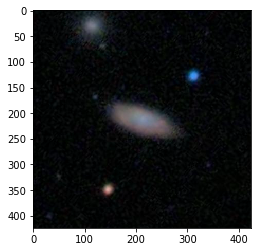

In [5]:
#Before image processing
sample_img = cv2.imread("E:/Galaxy Zoo/Data/images_training_rev1/Train/100204.jpg")
plt.imshow(sample_img)

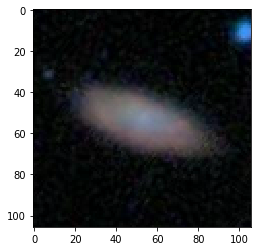

In [6]:
#After Image processing
sample_img = img_processor("E:/Galaxy Zoo/Data/images_training_rev1/Train/100204.jpg")
plt.imshow(sample_img)

In [7]:
cls = df.loc[100204].values
print("Galaxy Class: "+labels[np.argmax(cls)])

Galaxy Class: Class6.2


In [55]:
from keras.models import Sequential, Model,load_model
from keras.layers import Add,Input,Dense,Dropout,BatchNormalization,Activation,Flatten,Conv2D,MaxPooling2D,ZeroPadding2D,Lambda,AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.optimizers import SGD, RMSprop, Adam, Adagrad
from keras.initializers import glorot_uniform

In [9]:
def Conv(model,layers,filters):
    for i in range(layers):
        model.add(ZeroPadding2D((1,1))) 
        model.add(Conv2D((filters), kernel_size = (3,3), activation = 'relu'))
        
    model.add(MaxPooling2D(pool_size=(2,2), strides = (2,2)))

    
def FC_block(model,filters):
    model.add(Dense(filters, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
def VGG19():
    model = Sequential()
    model.add(Lambda(lambda x : x, input_shape=(106,106,3)))

    Conv(model,2,64)
    Conv(model,2,128)
    Conv(model,4,256)
    Conv(model,4,512)
    Conv(model,4,512)
    
    model.add(Flatten())
    FC_block(model,4096)
    FC_block(model,4096)
    FC_block(model,1000)
    
    model.add(Dense(37))
    model.add(Activation("softmax"))

    return model

def VGG16():
    model = Sqeuential()
    model.add(Lambda(lambda x:x, input_shape=(106,106,3)))
    
    Conv(model,2,64)
    Conv(model,2,128)
    Conv(model,3,256)
    Conv(model,3,512)
    Conv(model,3,512)
    
    model.add(Flatten())
    FC_block(model,4096)
    FC_block(model,4096)
    FC_block(model,4096)
    
    model.add(Dense(37))
    model.add(Activation("softmax"))
    
    return model

In [10]:
#ResNet Implementation block

def convolution_block(X, f_shape, filters, stage, block, stride = 2):
    '''
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f_shape -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    '''
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
 
    F1,F2,F3 = filters
    
    X_shortcut = X
    
    #Main Path
    #first component
    X = Conv2D(filters = F1, kernel_size=(1,1), strides = (stride,stride), name = conv_name_base+'2a', 
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base+'2a')(X)
    X = Activation('relu')(X)
    
    #Second Component
    X = Conv2D(filters = F2, kernel_size = (f_shape,f_shape), strides = (1,1), padding = 'same', name = conv_name_base+'2b', 
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base+'2b')(X)
    X = Activation('relu')(X)
    
    #Third Component
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'valid', name = conv_name_base+'2c', 
               kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base+'2c')(X)
    
    #Shortcut Path
    X_shortcut = Conv2D(filters = F3, kernel_size = (1,1), strides = (stride,stride), padding = 'valid', name = conv_name_base+'1',
                       kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base+'1')(X_shortcut)
    
    #Final
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X


def identity_block(X, f_shape, filters, stage, block):
    """
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    F1,F2,F3 = filters
    
    X_shortcut = X
    
    #Main Path
    #first component
    X = Conv2D(filters = F1, kernel_size = (1,1), strides = (1,1), padding = 'valid', name = conv_name_base+"2a",
              kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base+'2a')(X)
    X = Activation('relu')(X)
    
    #second component
    X = Conv2D(filters = F2, kernel_size = (f_shape,f_shape), strides = (1,1), padding = 'same', name = conv_name_base+"2b",
              kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base+'2b')(X)
    X = Activation('relu')(X)
    
    #Third component
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'valid', name = conv_name_base+'2c',
              kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base+'2c')(X)
    
    #Final
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X


def ResNet50(input_shape = (106,106,3), classes = 37):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    #Create a tensor of shape (106,106,3)
    X_input = Input(input_shape)
    
    #Zero padding to the tensor
    X = ZeroPadding2D((3,3))(X_input)
    
    #Stage 1
    X = Conv2D(64, (7,7), strides = (2,2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3,3), strides = (2,2))(X)
    
    #Stage 2
    X = convolution_block(X,f_shape = 3, filters = [64,64,256], stage = 2, block = 'a', stride = 1)
    X = identity_block(X, f_shape = 3, filters = [64,64,256], stage = 2, block = 'b')
    X = identity_block(X,3,[64,64,256], stage = 2, block = 'c')
    
    #Stage 3
    X = convolution_block(X, f_shape = 3, filters = [128,128,512], stage = 3, block = 'a', stride = 2)
    X = identity_block(X, 3, [128,128,512], stage = 3, block = 'b')
    X = identity_block(X, 3, [128,128,512], stage = 3, block = 'c')
    X = identity_block(X, 3, [128,128,512], stage = 3, block = 'd')
    
    #Stage 4
    X = convolution_block(X, f_shape = 3, filters = [256,256,1024], stage = 4, block = 'a', stride = 2)
    X = identity_block(X, 3, [256,256,1024], stage = 4, block = 'b')
    X = identity_block(X, 3, [256,256,1024], stage = 4, block = 'c')
    X = identity_block(X, 3, [256,256,1024], stage = 4, block = 'd')
    X = identity_block(X, 3, [256,256,1024], stage = 4, block = 'e')
    X = identity_block(X, 3, [256,256,1024], stage = 4, block = 'f')
    
    #Stage 5
    X = convolution_block(X, f_shape = 3, filters = [512,512,2048], stage = 5, block = 'a', stride = 2)
    X = identity_block(X, 3, [512,512,2048], stage = 5, block = 'b')
    X = identity_block(X, 3, [512,512,2048], stage = 5, block = 'c')
    
    #Average Pooling
    X = AveragePooling2D((2,2), name = "avg_pool")(X)
    
    
    X = Flatten()(X)
    X = Dense(classes, activation = 'softmax', name = 'fc'+str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    #create a model instance
    model = Model(inputs = X_input, outputs = X, name = 'ResNet50')
    
    return model

In [ ]:

model = ResNet50(input_shape = (106,106,3), classes = 37)

if(os.path.isfile("E:/Galaxy Zoo/Data/weights.hdf5")):
    model.load_weights("weights.hdf5")

model.compile(optimizer = Adagrad(lr=1e-4), loss='categorical_crossentropy', metrics = ['accuracy'])


In [57]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 106, 106, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 112, 112, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 53, 53, 64)   9472        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 53, 53, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [58]:
batch_size = 32

steps_per_batch = int(len(os.listdir(train_path))/batch_size)
val_steps_per_batch = int(len(os.listdir(validate_path))/batch_size)

checkpointer = ModelCheckpoint(filepath=r'E:\Galaxy Zoo\Data\weights.hdf5',verbose=1,save_best_only=True)

In [ ]:
history = model.fit_generator(
                    Batch_generator(train_path),
                    samples_per_epoch=steps_per_batch,
                    epochs = 2,
                    validation_data=Validation_generator(validate_path),
                    nb_val_samples=val_steps_per_batch,
                    verbose = 1,
                    callbacks = [tensorboard,checkpointer]
                   )

W0917 23:05:15.044286  7756 deprecation.py:323] From c:\users\shinigami shrek\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/1
1924/1924 [==============================] - 183s 95ms/step - loss: 43.5978 - acc: 0.6606 - val_loss: 40.5642 - val_acc: 0.4405

Epoch 00001: val_loss improved from inf to 40.56416, saving model to E:\Galaxy Zoo\Data\weights.hdf5


In [16]:
time_st = datetime.datetime.today().strftime('%Y-%m-%d')
model_name = "ResNet"+time_st+".model"
model.save("E:/Galaxy Zoo/Data/Models/"+model_name)

# Testing on a random validation image

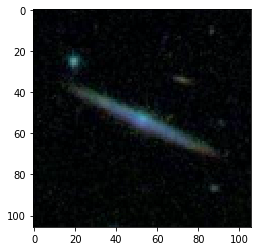

In [50]:
img_id = "752511.jpg"
X_test = img_processor("E:/Galaxy Zoo/Data/images_training_rev1/Validate/"+img_id)
X_test = X_test.reshape(1,106,106,3)
plt.imshow(X_test[0])

In [51]:
prediction = model.predict([X_test])

In [52]:
#Predicted Galaxy class
print("Galaxy Class: "+labels[np.argmax(prediction)])

Galaxy Class: Class1.2


In [53]:
#Actual Galaxy class
cls = df.loc[int(img_id[:-4])].values
print("Galaxy Class: "+labels[np.argmax(cls)])

Galaxy Class: Class1.2
